# alpha diversity meta-analysis

+ **目的**：对多个数据集的Shannon做meta-analysis  
+ **方法**：随机效应模型    
+ **主要步骤**：单个数据集内对Shannon的t.test,可以得到单个数据集的统计结果。用随机效应模型计算综合多个数据集的总效应
+ **方法参考**：Meta-analysis reveals reproducible gut microbiome alterations in response to a high-fat diet. 您可以点击[这里](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6708278/)获取原文。 文章也提供了原代码
+ **适用范围**：应该是可以对任意alpha div 拟合混合线性模型，参考文献也用于Firmicutes/Bacteroidetes
+ **注**：本notebook的代码是简化版的，仅以Shannon为例，方便说明每一步是做什么的。在Notebook:beegfs/projects/20190707-HP-eradication/analyses/illumina-meta-analysis/all-data-meta-analysis/alpha-diversity-foldchange/with-hp-final.ipynb.有写好的function对多个值同时计算的代码，可能不好理解，如有需要可参考

In [2]:
library(ggplot2)  
library(tidyverse) # for data  reshape
#library(readxl)
#library(MicrobeR)
#library(vegan)

## read data

读取示例数据

In [3]:
data <- read.csv('data.csv',row.names=1) %>% rownames_to_column("SampleID") 
row.names(data) <- data$SampleID
head(data)

,SampleID,Study,Group,Shannon
,<chr>,<chr>,<chr>,<dbl>
ERR1995049,ERR1995049,Study1,case,3.13783234
ERR1995038,ERR1995038,Study1,case,4.04552986
ERR1994996,ERR1994996,Study1,control,0.03592160
ERR1994997,ERR1994997,Study1,control,0.02694246
ERR1994992,ERR1994992,Study1,control,0.68194599
ERR1994989,ERR1994989,Study1,control,0.07928267


In [4]:
dim(data)

[1] 547   4

In [5]:
# over view the data
data %>%group_by(Study, Group) %>% summarize(count=n())

`summarise()` has grouped output by 'Study'. You can override using the
`.groups` argument.


Study,Group,count
<chr>,<chr>,<int>
Study1,case,9
Study1,control,21
Study2,case,84
Study2,control,41
Study3,case,36
Study3,control,56
Study4,case,40
Study4,control,54
Study5,case,110


共5个数据集，每个数据集都有control和case和两个组，

## analysis

In [6]:
data <- data %>% left_join(data %>% group_by(Study,Group) %>% 
                           summarize(mean=mean(log2(Shannon)))%>%  # 每个数据集内每个组算平均值
                       spread(key=Group,value=mean) %>% 
                       rename(mean_log2case=case, mean_log2control=control)) %>%
                       mutate(log2FC=log2(Shannon)-mean_log2control)  # 以对照组的平均值为标准对数据进行标准化

`summarise()` has grouped output by 'Study'. You can override using the
`.groups` argument.
Joining, by = "Study"


In [7]:
head(data)
# 得到了每个数据集每个组的平均值

,SampleID,Study,Group,Shannon,mean_log2case,mean_log2control,log2FC
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ERR1995049,Study1,case,3.13783234,-1.185529,-3.367568,5.0173360
2,ERR1995038,Study1,case,4.04552986,-1.185529,-3.367568,5.3838964
3,ERR1994996,Study1,control,0.03592160,-1.185529,-3.367568,-1.4314368
4,ERR1994997,Study1,control,0.02694246,-1.185529,-3.367568,-1.8464070
5,ERR1994992,Study1,control,0.68194599,-1.185529,-3.367568,2.8152971
6,ERR1994989,Study1,control,0.07928267,-1.185529,-3.367568,-0.2892829


In [8]:
#t.test(log2FC~Group, data=data, conf.int=TRUE, conf.level=0.95)

In [9]:
stat <- data %>% group_by(Study) %>%
do(broom::tidy(t.test(log2FC~Group, data=., conf.int=TRUE, conf.level=0.95)))%>%  # 每个数据集内部control组和case组做t检验
select(Study,
       log2FC=estimate, 
       Pvalue=p.value, 
       CI_low=conf.low, 
       CI_high=conf.high) #

stat 

Study,log2FC,Pvalue,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Study1,2.182038854,1.764055e-01,-1.1592242,5.5233019
Study2,-0.803845747,3.349214e-07,-1.0980695,-0.5096220
Study3,0.009311609,9.233430e-01,-0.1830829,0.2017061
Study4,0.028929426,6.733176e-01,-0.1069321,0.1647909
Study5,0.781684184,1.421266e-02,0.1586050,1.4047634


In [10]:
data$Group <- factor(data$Group,levels=(c('control','case')))
# 把group列变为factor，对照组在前，不然算出来的值不知道是那个组比那个组，
# 按照这个写法，后面算的foldchange是case基于control，当foldchang大于0，表示case组高于control组

In [11]:
# 构建一个空的data.frame
REM <- tibble(Study=character(0), 
                  log2FC=numeric(0), Pvalue=numeric(0), 
              CI_low=numeric(0), CI_high=numeric(0))
REM

Study,log2FC,Pvalue,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>


In [12]:
fit <- lmerTest:::lmer(log2FC~Group+(1|Study), data)  #fit ramdom effect module
cf <- confint(fit,level = 0.95) # calculate CI

Computing profile confidence intervals ...



In [13]:
REM <- bind_rows(REM, tibble(
Study="Meta", 
log2FC=summary(fit)$coefficients["Groupcase", "Estimate"], 
Pvalue=anova(fit)$`Pr(>F)`,  
CI_low=cf["Groupcase",1],  
CI_high=cf["Groupcase",2] 
)) # 从random effect model中提取结果，

In [14]:
REM 

Study,log2FC,Pvalue,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Meta,0.2312372,0.1125347,-0.05989925,0.5129764


In [15]:
res <- stat %>% bind_rows(REM) %>%
mutate(Significance=case_when(
Pvalue<0.05 & log2FC>0 ~ "* higher in Case" ,
Pvalue<0.05 & log2FC<0 ~ "* higher in Control",
TRUE~"ns")) # random effect module 结果和单个数据集的结果合并起来，

In [16]:
res

Study,log2FC,Pvalue,CI_low,CI_high,Significance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Study1,2.182038854,1.764055e-01,-1.15922424,5.5233019,ns
Study2,-0.803845747,3.349214e-07,-1.09806949,-0.5096220,* higher in Control
Study3,0.009311609,9.233430e-01,-0.18308289,0.2017061,ns
Study4,0.028929426,6.733176e-01,-0.10693205,0.1647909,ns
Study5,0.781684184,1.421266e-02,0.15860500,1.4047634,* higher in Case
Meta,0.231237181,1.125347e-01,-0.05989925,0.5129764,ns


## Visualize the results

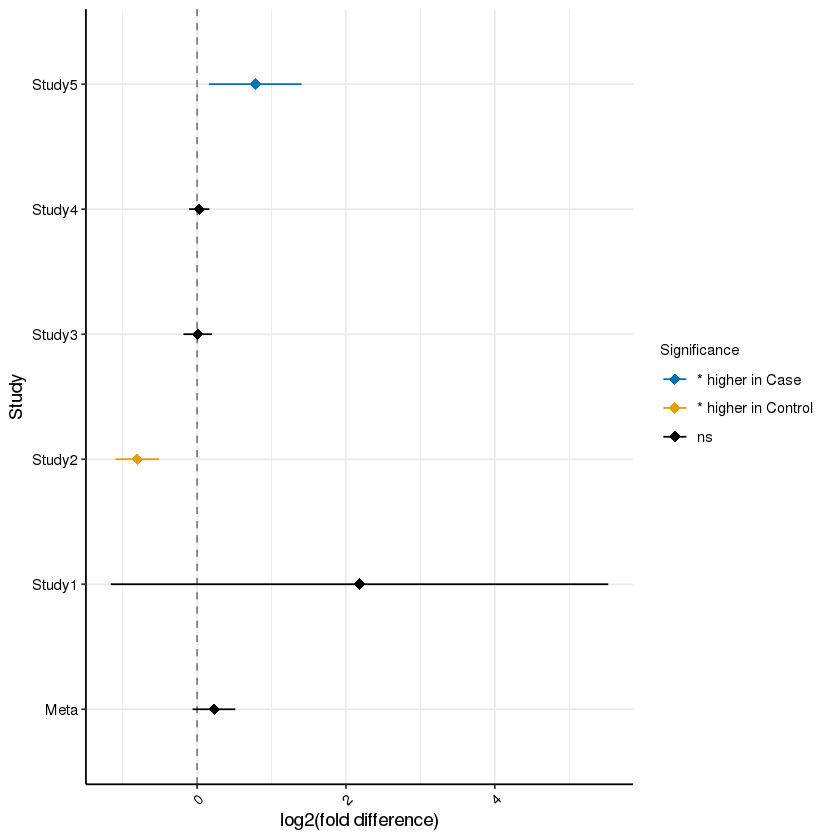

In [17]:
size=9

ggplot(res,aes(x=log2FC, y=Study, color=Significance)) +  
geom_vline(xintercept = 0, linetype="dashed", color="grey50") +
geom_errorbarh(aes(xmin=CI_low, xmax=CI_high), height=0 ) +
geom_point(shape=18,size=3) +
theme_bw() +
scale_color_manual(values=c("#0072B2", "#E69F00", "black"))  +
theme(panel.border = element_blank(), axis.line = element_line(),
      plot.title = element_text(hjust = 0.5)) + 
theme(axis.text.x=element_text(angle=45, hjust=1,size=size),
      axis.text.y=element_text(size=size),
      axis.text = element_text(size = size,colour = 'black'),
      legend.title = element_text(size = size),
      legend.text = element_text(size = size))+
      xlab('log2(fold difference)')+
      labs(y='Study')    

如图所示，在study1，study3，study4中，control组和case的Shannon无显著差异，在study2中control组显著高于case组，在study5中，case组Shannon显著高于control组，综合多个数据集看control组和case的Shannon无显著差异

## function 

In [18]:


# metaca<- function(data,study='Study',group='Group',Control='control',Case='case',value='Value',ci=0.95){
    
    
#     # prepare data
#     names(data)[names(data)==study] <- 'Study'
#     names(data)[names(data)==group] <- 'Group'
#     names(data)[names(data)==value] <- 'Value'
    
#     data[which(data['Group']== Control),'Group'] <-'control'
#     data[which(data['Group']== Case),'Group'] <-'case'
    
#     data <- data %>% select(Study, Group, Value)
    
#     # t test for each study bwt group
#     data <- data %>% left_join(data %>% group_by(Study,Group) %>% summarize(mean=mean(log2(Value)))%>%
#                            spread(key=Group,value=mean) %>% 
#                            rename(mean_log2case=case, mean_log2control=control)) %>%
#                            mutate(log2FC=log2(Value)-mean_log2control)    
    
#     stat <- data %>% group_by(Study) %>%
#     do(broom::tidy(t.test(log2FC~Group, data=., conf.int=TRUE, conf.level=0.95)))%>%
#     select(Study,
#            log2FC=estimate, 
#            Pvalue=p.value, 
#            CI_low=conf.low, 
#            CI_high=conf.high)
    
#     REM <- tibble(Study=character(0), 
#                       log2FC=numeric(0), Pvalue=numeric(0), 
#                   CI_low=numeric(0), CI_high=numeric(0))

    
#     data$Group <- factor(data$Group,levels=(c('control','case')))
#     fit<-lmerTest:::lmer(log2FC~Group+(1|Study), data)  #fit module
#     cf<-confint(fit,level = 0.95)

#     REM<-bind_rows(REM, tibble(
#     Study="Meta", 

#     log2FC=summary(fit)$coefficients["Groupcase", "Estimate"], 
#     Pvalue=anova(fit)$`Pr(>F)`,  
#     CI_low=cf["Groupcase",1],  
#     CI_high=cf["Groupcase",2] 
#     ))

#     res <- stat %>% bind_rows(REM) %>%
#     mutate(Significance=case_when(
#     Pvalue<0.05 & log2FC>0 ~ sprintf("* higher in %s",Case),
#     Pvalue<0.05 & log2FC<0 ~ sprintf("* higher in %s",Control),
#     TRUE~"ns"
#     )) 

#     return(res)
# }
